# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(av_running_speed, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(av_running_speed, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate) #fine grain the time array
x_sampling = np.floor(np.interp(t_sampling, t, x)) # interpolate the fine grained x array
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate #compute the instantaneous firing rate from the previously defined RFs of the place cells along the entire trajectory + some noise term that is the same for all neurons.
    spikes_loc = np.random.poisson(inst_rate/sampling_rate) # compute the poisson distributed spike numer per neurons at every time bin
    sp = np.argwhere(spikes_loc) # returns the indices in the trajectory where a spike occurs
    t_sp = t_sampling[sp] # gives the times of the spikes for neuron i
    spikes.append(t_sp) # appends the spike times of all neurons.

spike_positions = [np.interp(s, t, x) for s in spikes]

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


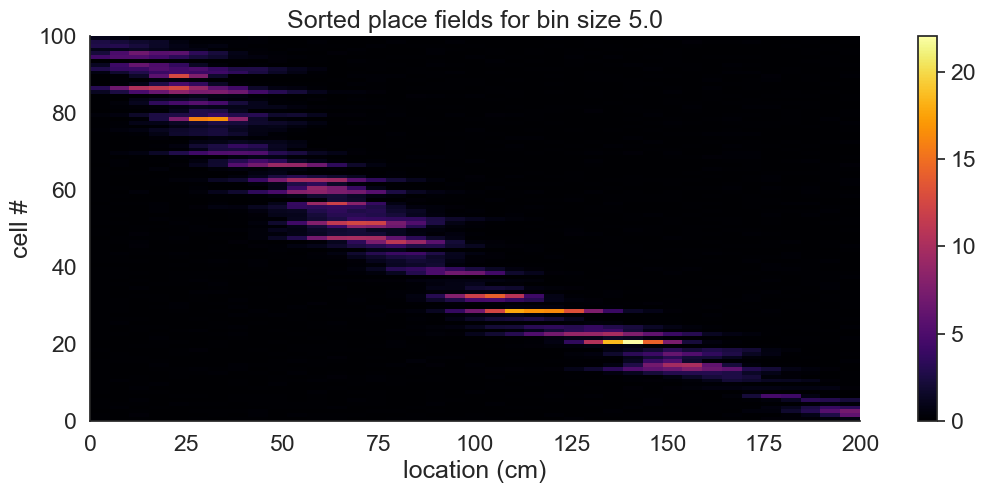

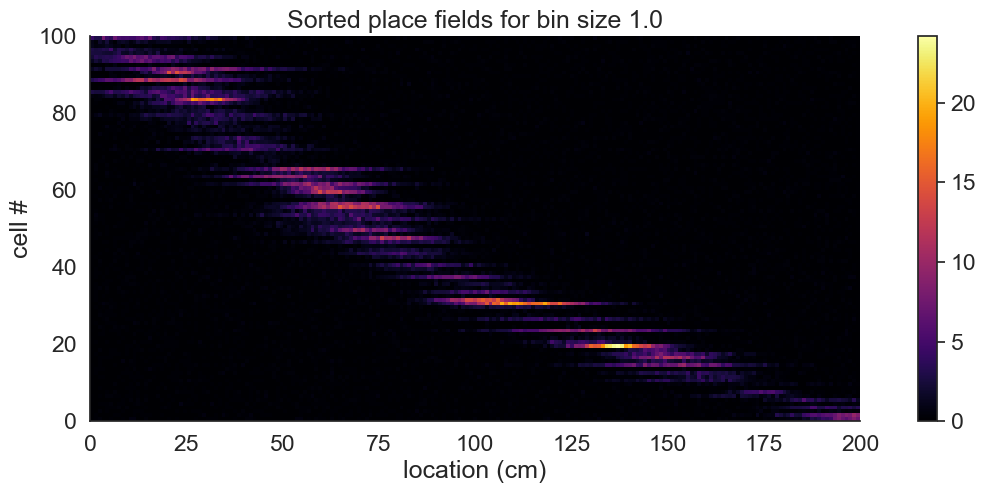

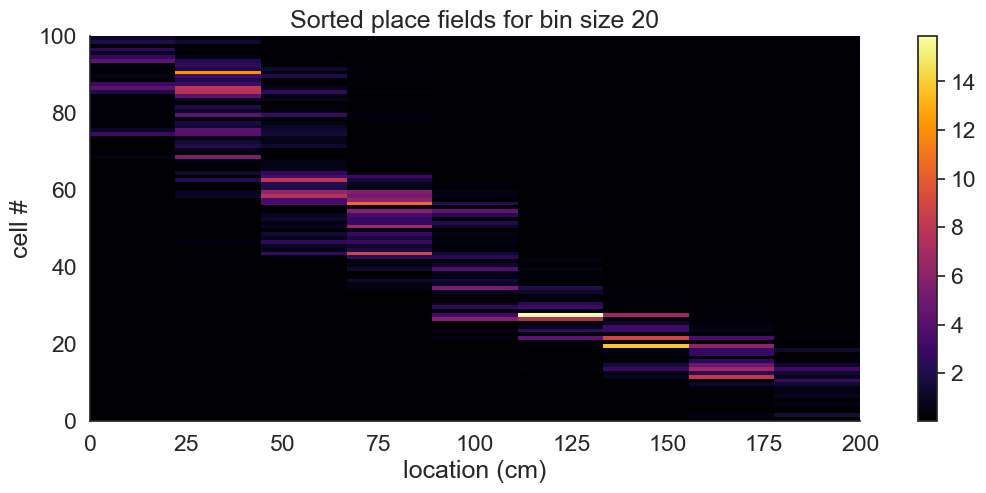

In [3]:
def plot_estimated_rfs(bin_size):   
    space_bins = np.arange(0., 200., bin_size)

    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    plt.figure(figsize=(15,5))
    plt.title(f"Sorted place fields for bin size {bin_size}")
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

plot_estimated_rfs(5.)
plot_estimated_rfs(1.)
plot_estimated_rfs(20)


For the fine-grained bins, we can see that the rough shape of the receptive fields is the same as in the original plot. However, as one would expect, the structure is less smooth and more asymmetric.

For the coarse-grained bins (I chose a very large size of 20) we can see that the symmetry breaks down completely and the receptive fields are bigger (20 cm is insufficient, so it has to take 40cm or even 60 for some cells).

100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


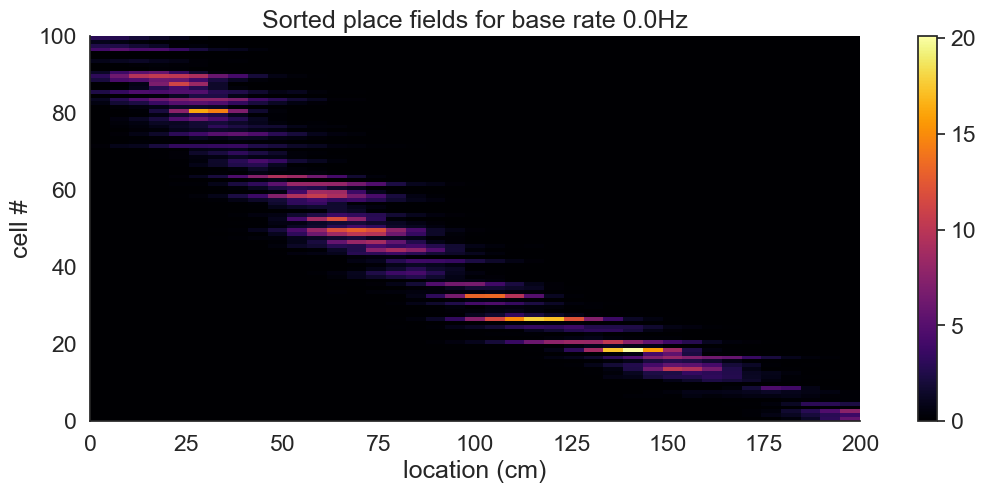

100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


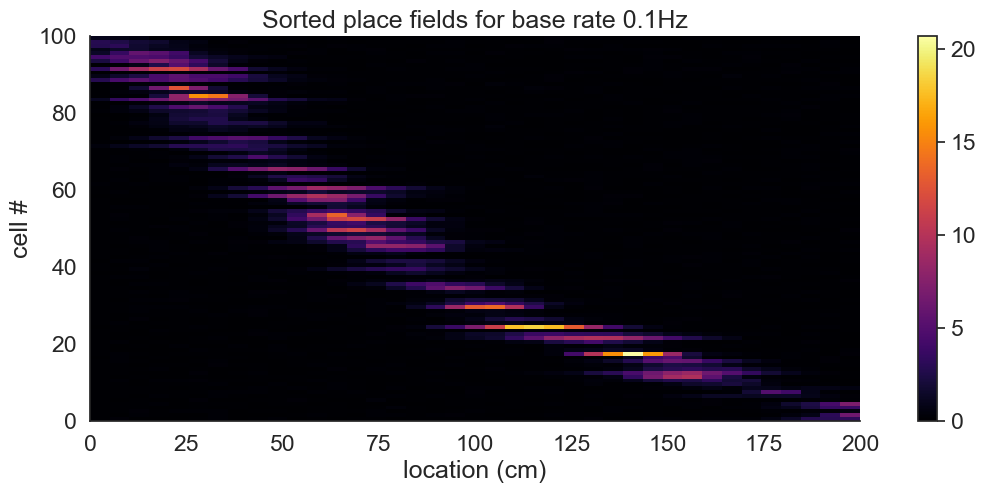

100%|██████████| 100/100 [00:28<00:00,  3.45it/s]


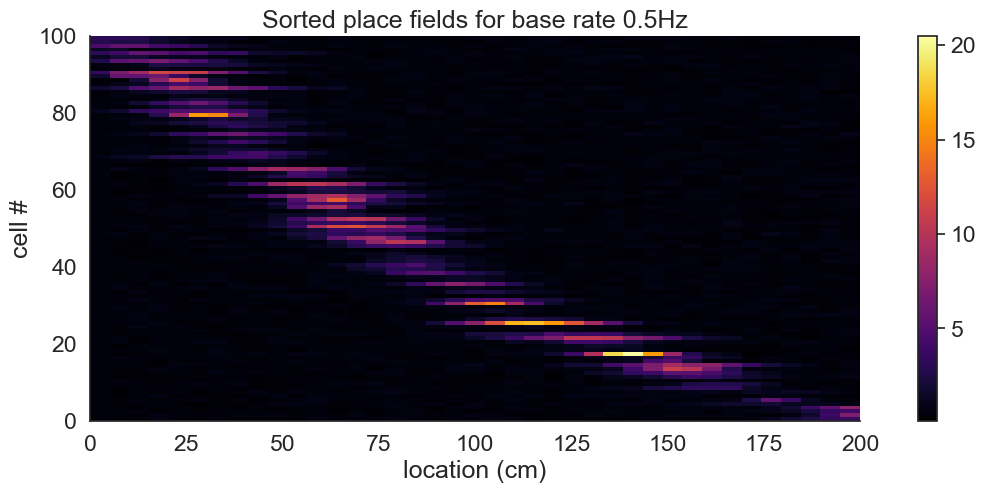

100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


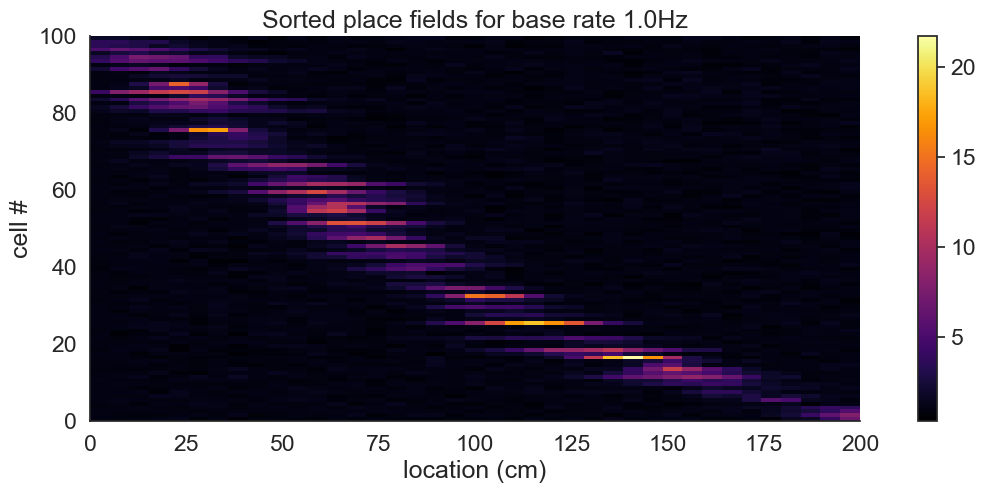

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


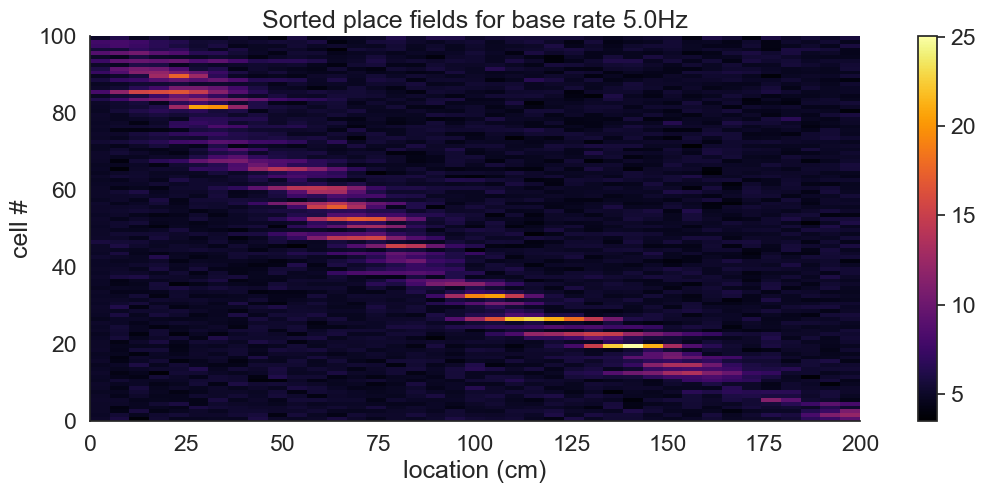

100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


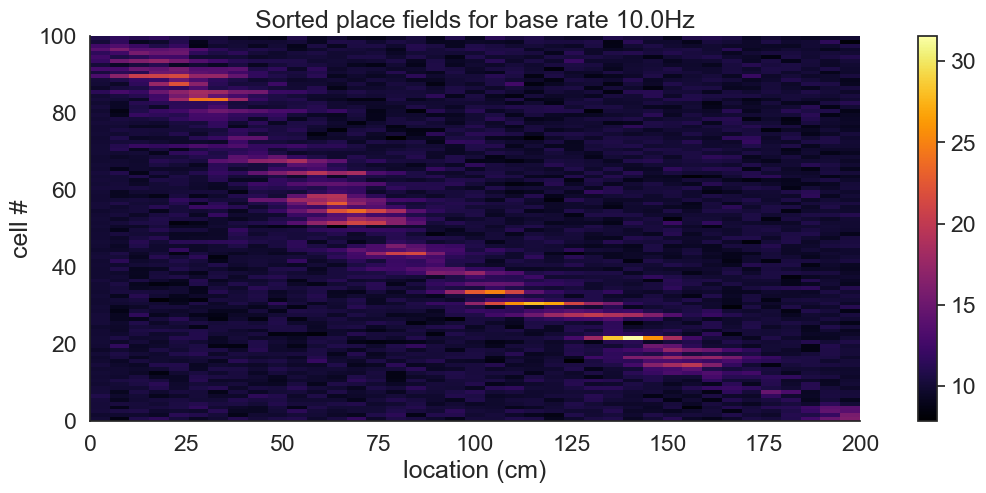

In [4]:
def plot_different_noises(noise_firing_rate):   
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate #compute the instantaneous firing rate from the previously defined RFs of the place cells along the entire trajectory + some noise term that is the same for all neurons.
        spikes_loc = np.random.poisson(inst_rate/sampling_rate) # compute the poisson distributed spike numer per neurons at every time bin
        sp = np.argwhere(spikes_loc) # returns the indices in the trajectory where a spike occurs
        t_sp = t_sampling[sp] # gives the times of the spikes for neuron i
        spikes.append(t_sp) # appends the spike times of all neurons.

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., 200., 5.)

    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    plt.figure(figsize=(15,5))
    plt.title(f"Sorted place fields for base rate {noise_firing_rate}Hz")
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()
    plt.show()

for noise in [0., 0.1, .5, 1., 5., 10.]:
    plot_different_noises(noise)


### Discussion:
We can see that in the last two plots, the locality/sparsity of the place fields breaks down. Depending on the experimental setup this sort of problem will occur for biological data which is much noiser than our synthetic data. There are multiple ways to deal with this. One way would be to introduce a threshold to the recpetive fields, such that all positions with an estimated firing rate below a certain value will be set to 0. Another way would be to enforce locality by applying a taper.

100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


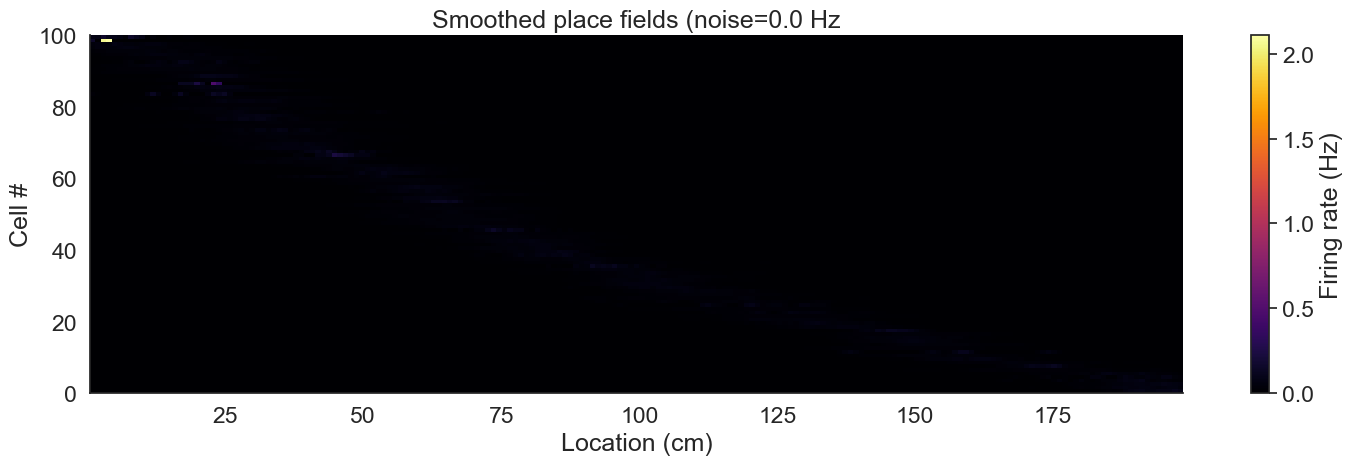

100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


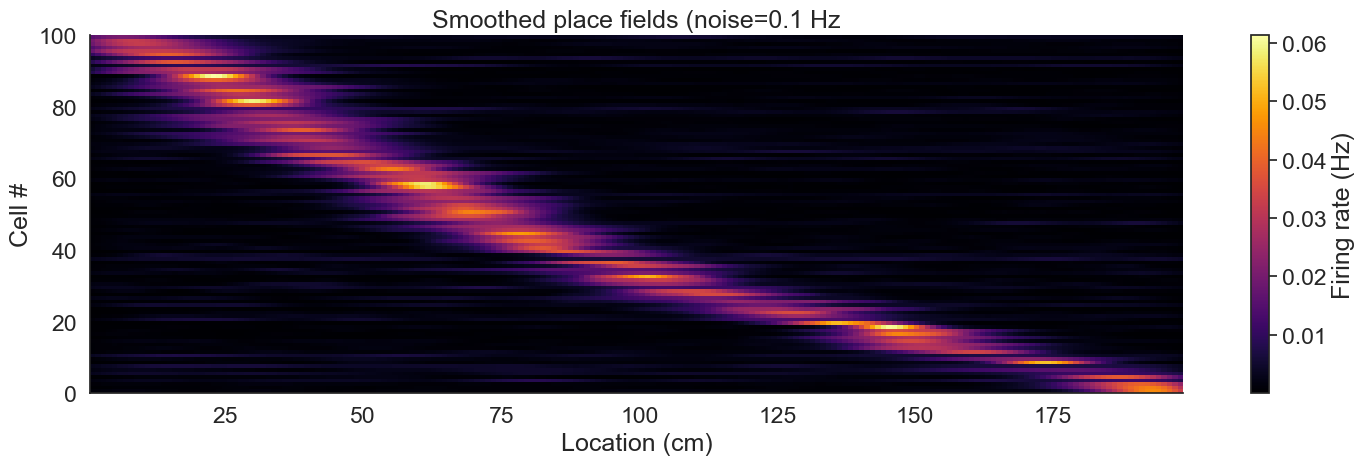

100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


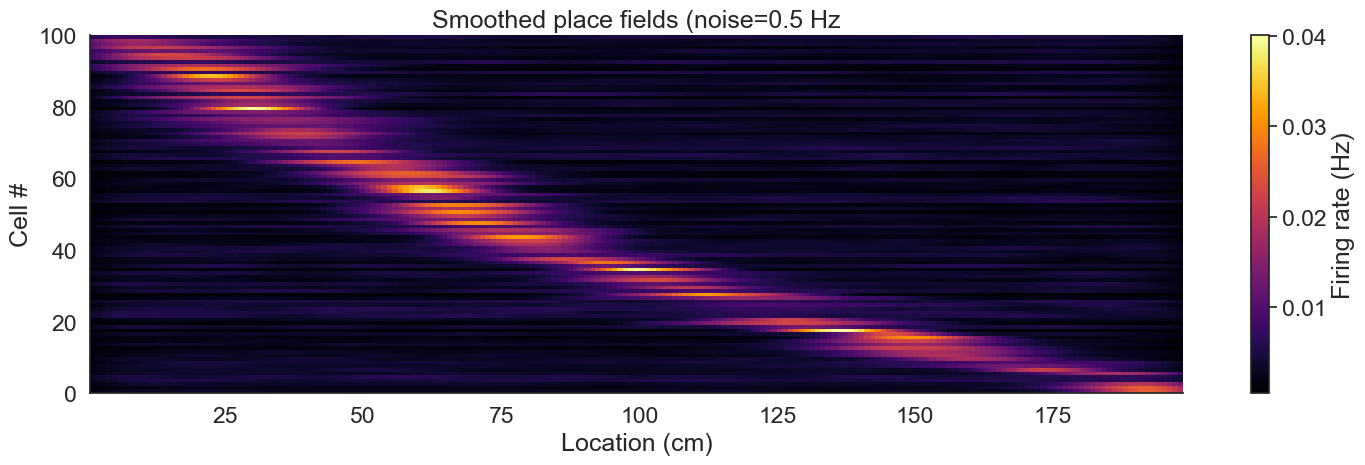

100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


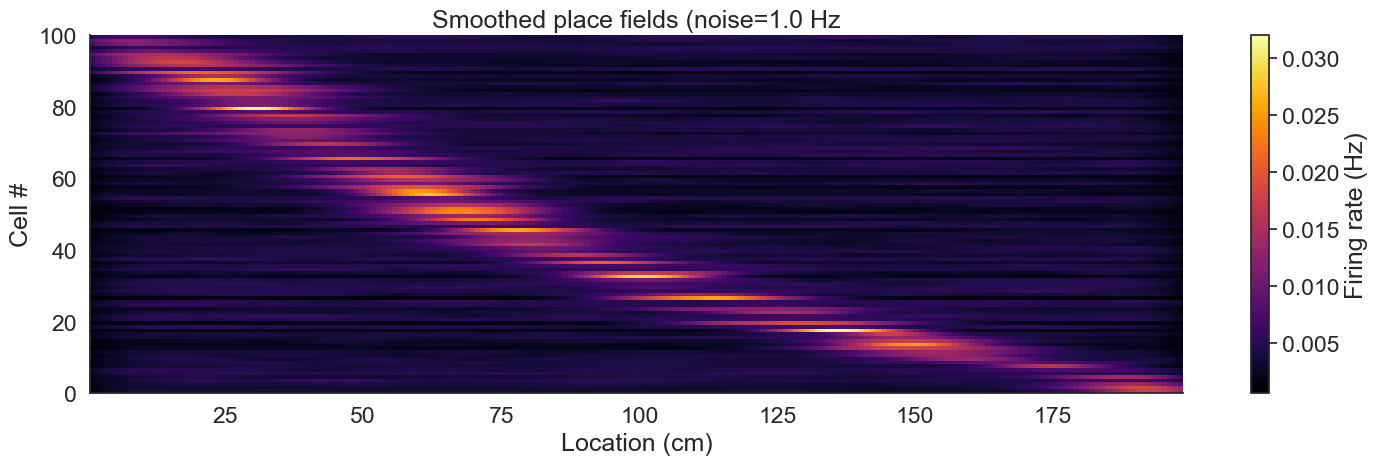

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


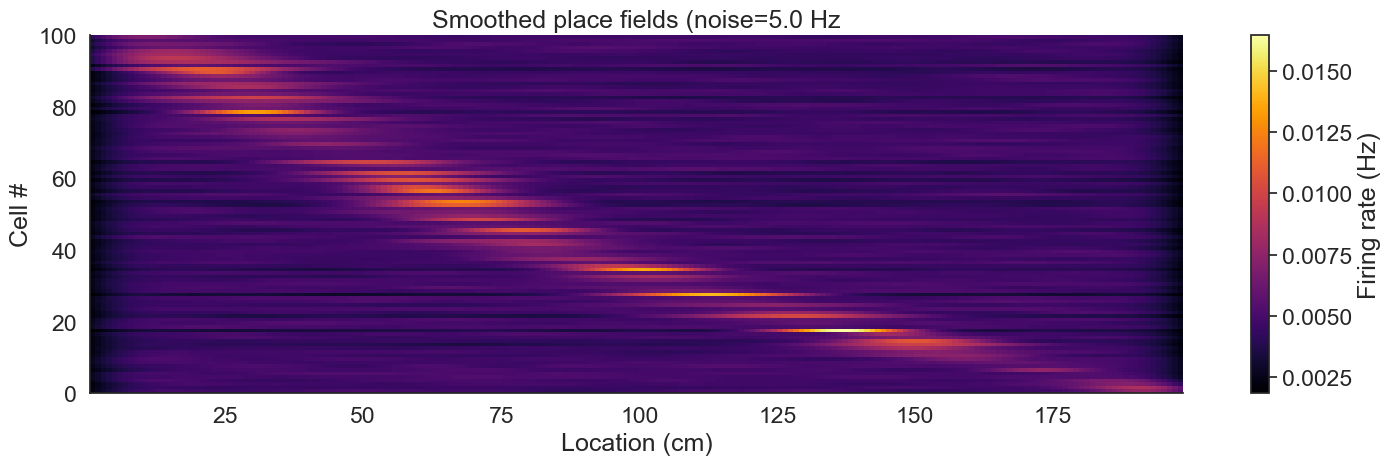

100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


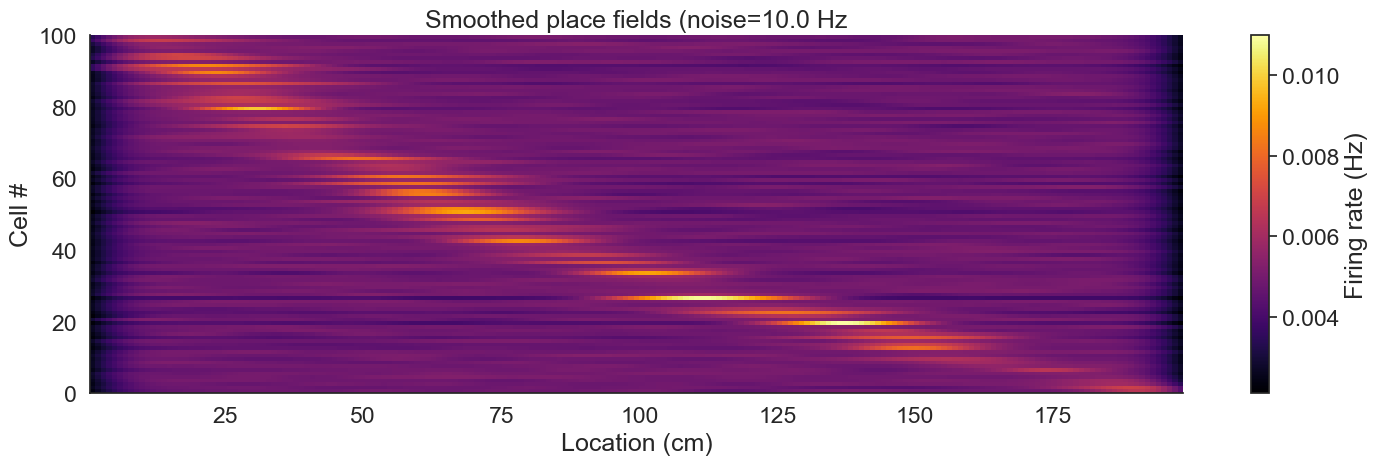

In [5]:
from scipy.stats import gaussian_kde
def plot_different_noises_with_smoother(noise_firing_rate):   
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate #compute the instantaneous firing rate from the previously defined RFs of the place cells along the entire trajectory + some noise term that is the same for all neurons.
        spikes_loc = np.random.poisson(inst_rate/sampling_rate) # compute the poisson distributed spike numer per neurons at every time bin
        sp = np.argwhere(spikes_loc) # returns the indices in the trajectory where a spike occurs
        t_sp = t_sampling[sp] # gives the times of the spikes for neuron i
        spikes.append(t_sp) # appends the spike times of all neurons.

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., 200., 1.)

    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 
    # Now smooth each row with gaussian_kde
    smoothed_maps = np.zeros_like(firing_rate_maps)
    bin_centers = (space_bins[:-1] + space_bins[1:]) / 2.
    
    for i, rate_map in enumerate(firing_rate_maps):
        # Only smooth if there are non-zero values
        if np.sum(rate_map) > 0:
            non_zero_mask = rate_map > 0
            if np.any(non_zero_mask):
                data_points = bin_centers[non_zero_mask]
                weights = rate_map[non_zero_mask]
                
                try:
                    kde = gaussian_kde(dataset=data_points, weights=weights, bw_method=0.1)
                    smoothed_maps[i, :] = kde(bin_centers)
                except:
                    # If KDE fails, use original rate map
                    smoothed_maps[i, :] = rate_map
            else:
                smoothed_maps[i, :] = rate_map
        else:
            smoothed_maps[i, :] = rate_map
    
    # Sort by peak location and plot
    peak_locations = smoothed_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    
    plt.figure(figsize=(15, 5))
    plt.title(f"Smoothed place fields (noise={noise_firing_rate} Hz")
    plt.imshow(smoothed_maps[ix, :], 
               aspect='auto',
               cmap='inferno',
               extent=[bin_centers[0], bin_centers[-1], 0, smoothed_maps.shape[0]])
    plt.xlabel('Location (cm)')
    plt.ylabel('Cell #')
    plt.colorbar(label='Firing rate (Hz)')
    plt.tight_layout()
    plt.show()

for noise in [0., 0.1, .5, 1., 5., 10.]:
    plot_different_noises_with_smoother(noise)

We can see that the problem of applying a smoother without any threshold or similar technology to deal with the noise, causes a very homogeneous background activity for all neurons along the entire track.

100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


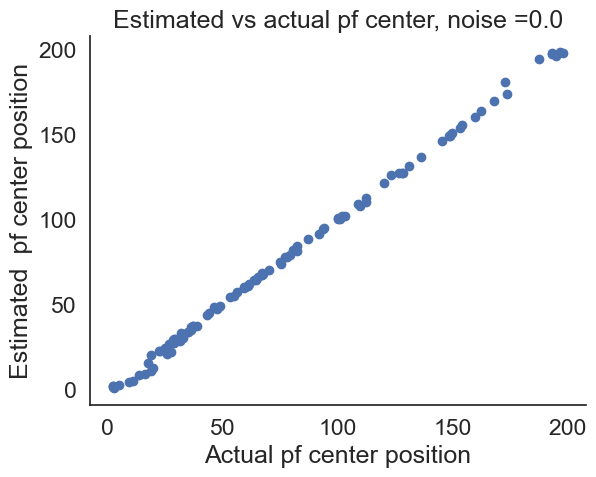

100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


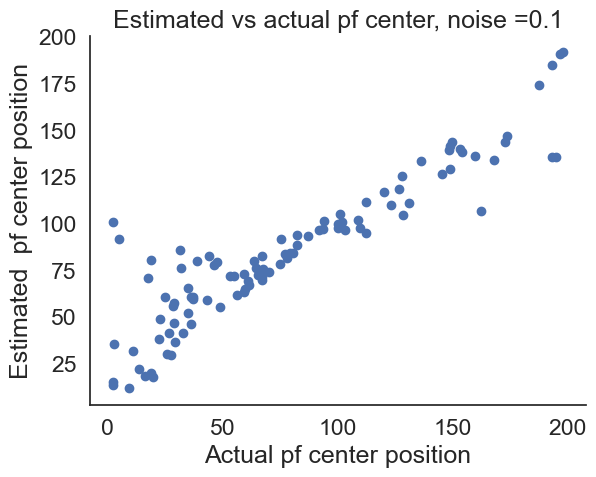

100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


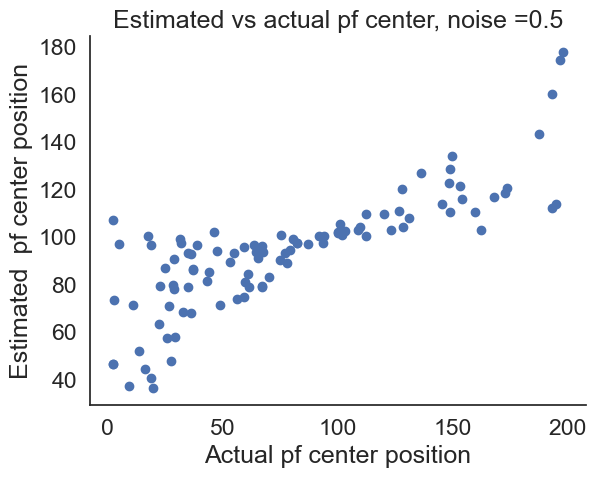

100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


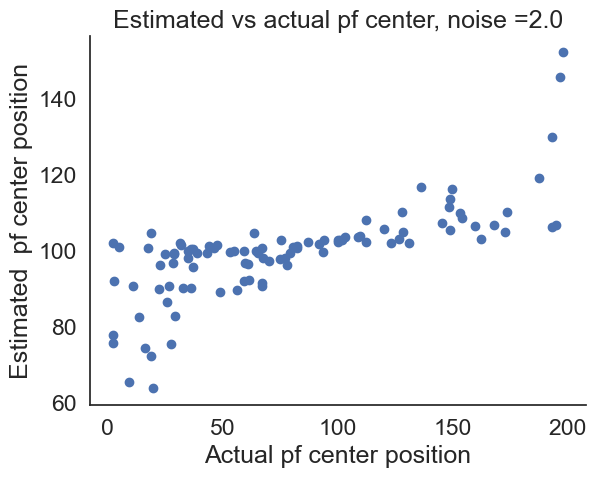

In [6]:
def plot_center_estimate(noise):
    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 30 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(av_running_speed, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(av_running_speed, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate) #fine grain the time array
    x_sampling = np.floor(np.interp(t_sampling, t, x)) # interpolate the fine grained x array
    noise_firing_rate = 0.1 # the baseline noise firing rate
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise #compute the instantaneous firing rate from the previously defined RFs of the place cells along the entire trajectory + some noise term that is the same for all neurons.
        spikes_loc = np.random.poisson(inst_rate/sampling_rate) # compute the poisson distributed spike numer per neurons at every time bin
        sp = np.argwhere(spikes_loc) # returns the indices in the trajectory where a spike occurs
        t_sp = t_sampling[sp] # gives the times of the spikes for neuron i
        spikes.append(t_sp) # appends the spike times of all neurons.

    spike_positions = [np.interp(s, t, x) for s in spikes]

    estimated_centers = np.zeros_like(pf_centers)
    for i, cell_spikes in enumerate(spike_positions):
        estimated_centers[i] = np.mean(cell_spikes)
    plt.plot(pf_centers, estimated_centers, 'o')
    plt.title(f"Estimated vs actual pf center, noise ={noise}")
    plt.ylabel("Estimated  pf center position")
    plt.xlabel("Actual pf center position")
    plt.show()

for noise in [0., 0.1, 0.5, 2.0]:
    plot_center_estimate(noise)


We can see that the noise level determines the accuracy of the center esimate.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

/var/folders/1_/jd84lw7d3qd408fwkk21ctvc0000gn/T/ipykernel_32791/958014859.py:5: RuntimeWarning: divide by zero encountered in log2
  I = np.sum(rate*p*np.log2((rate)/avrg_rate))
/var/folders/1_/jd84lw7d3qd408fwkk21ctvc0000gn/T/ipykernel_32791/958014859.py:5: RuntimeWarning: invalid value encountered in multiply
  I = np.sum(rate*p*np.log2((rate)/avrg_rate))


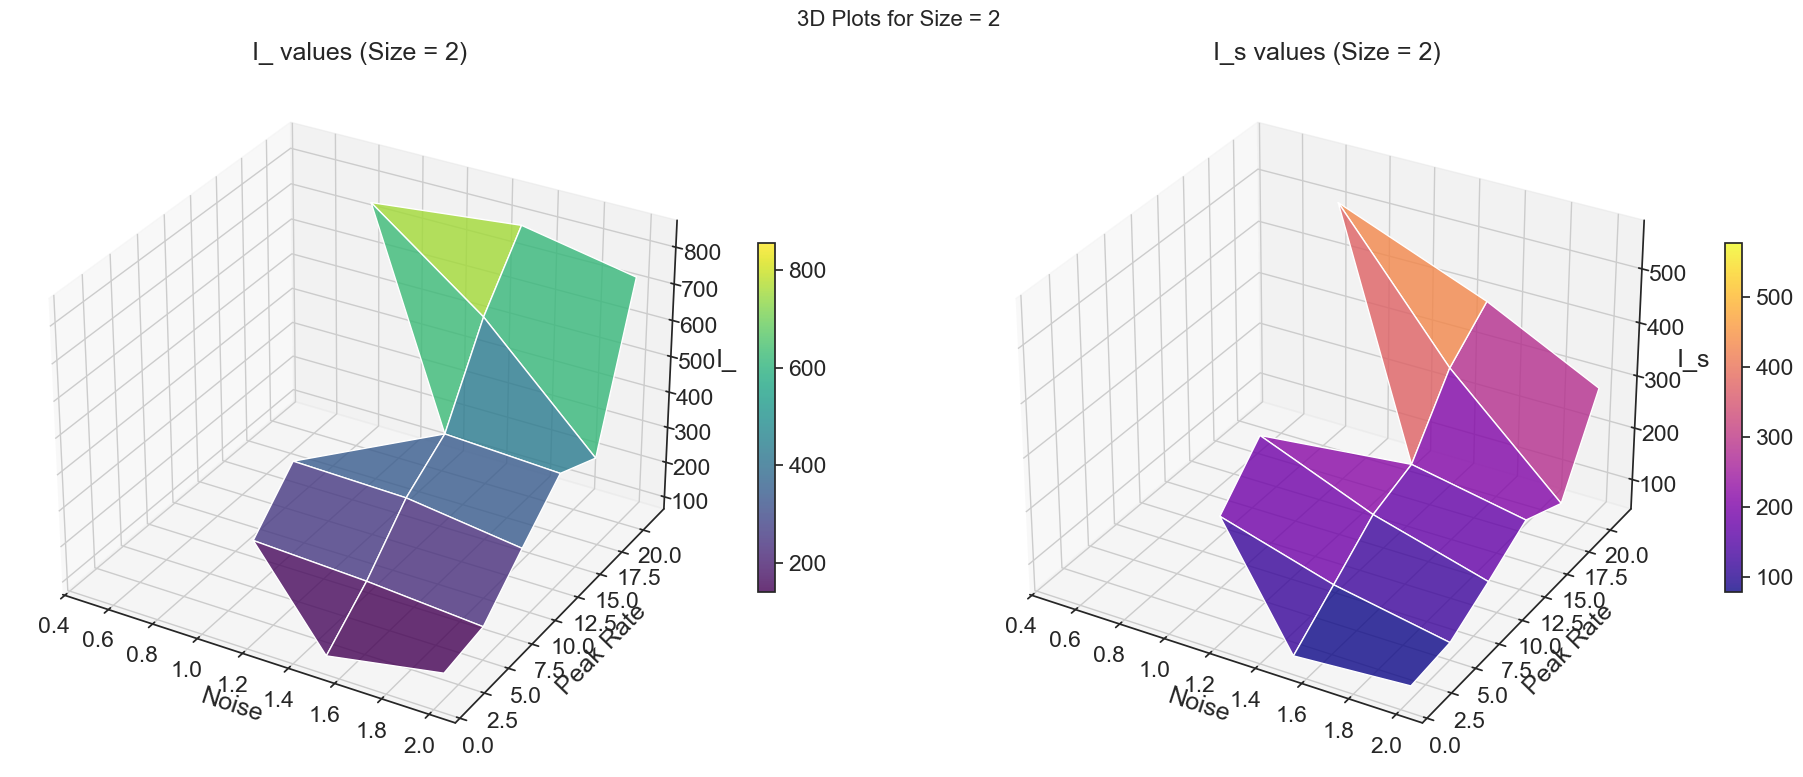

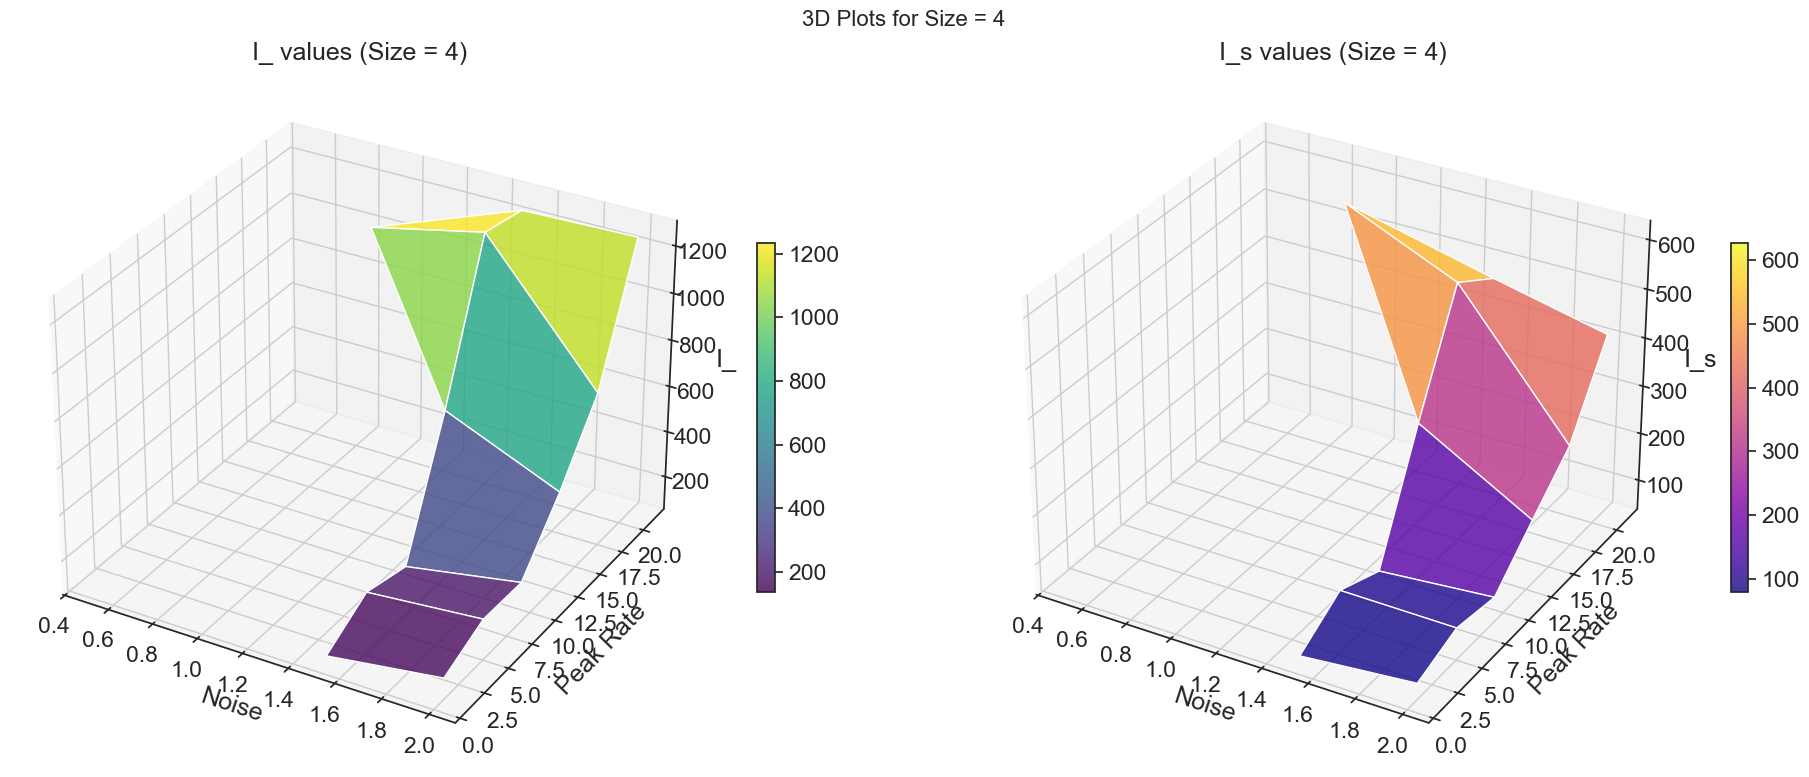

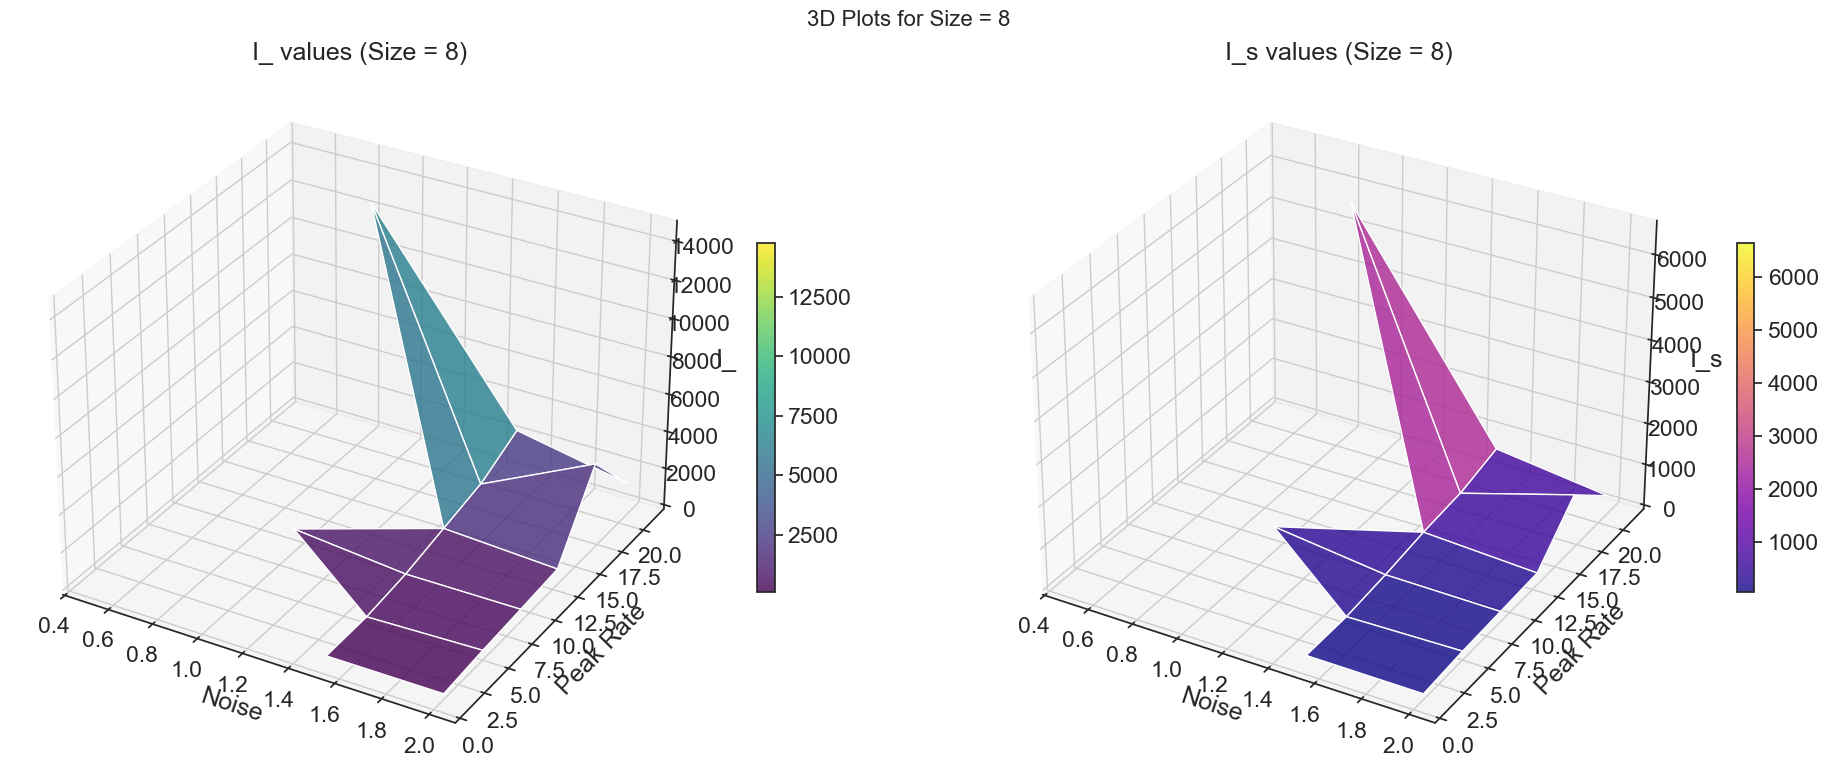

In [38]:
def I(firing_rate_maps, occupancy):
    rate = firing_rate_maps
    p = occupancy
    avrg_rate = np.mean(rate)
    I = np.sum(rate*p*np.log2((rate)/avrg_rate))
    return I


def generate_I(peak_firing_rate, place_cell_size, baseline_noise):  
    n_cells = 1
    track_length = 200. # the length of our linear track (eg in centimeter)
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = place_cell_size*np.ones(n_cells)
    pf_rate = peak_firing_rate*np.ones(n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 30 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(av_running_speed, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(av_running_speed, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate) #fine grain the time array
    x_sampling = np.floor(np.interp(t_sampling, t, x)) # interpolate the fine grained x array
    noise_firing_rate = baseline_noise
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate #compute the instantaneous firing rate from the previously defined RFs of the place cells along the entire trajectory + some noise term that is the same for all neurons.
        spikes_loc = np.random.poisson(inst_rate/sampling_rate) # compute the poisson distributed spike numer per neurons at every time bin
        sp = np.argwhere(spikes_loc) # returns the indices in the trajectory where a spike occurs
        t_sp = t_sampling[sp] # gives the times of the spikes for neuron i
        spikes.append(t_sp) # appends the spike times of all neurons.

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., 200., 1.)

    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    I_ = I(firing_rate_maps, occupancy)
    I_s = I_/np.mean(firing_rate_maps)

    return I_, I_s

from mpl_toolkits.mplot3d import Axes3D



# Parameters
sizes = [2, 4, 8]
noise_values = np.arange(0.5, 2.5, 0.5)
peak_rates = np.arange(1, 22, 4)

# Create meshgrid for 3D plotting
noise_grid, peak_rate_grid = np.meshgrid(noise_values, peak_rates)

# Create plots for each size
for n, size in enumerate(sizes):
    # Initialize arrays to store I_ and I_s values
    I_values = np.zeros_like(noise_grid)
    I_s_values = np.zeros_like(noise_grid)
    
    # Generate data for all combinations
    for i, noise in enumerate(noise_values):
        for j, peak_rate in enumerate(peak_rates):
            I_, I_s = generate_I(peak_rate, size, noise)
            I_values[j, i] = I_  # j corresponds to peak_rate, i to noise
            I_s_values[j, i] = I_s
    
    # Create figure with subplots for I_ and I_s
    fig = plt.figure(figsize=(20, 8))
    
    # Plot I_ (left subplot)
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(noise_grid, peak_rate_grid, I_values, 
                            cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Noise')
    ax1.set_ylabel('Peak Rate')
    ax1.set_zlabel('I_')
    ax1.set_title(f'I_ values (Size = {size})')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # Plot I_s (right subplot)
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(noise_grid, peak_rate_grid, I_s_values, 
                            cmap='plasma', alpha=0.8)
    ax2.set_xlabel('Noise')
    ax2.set_ylabel('Peak Rate')
    ax2.set_zlabel('I_s')
    ax2.set_title(f'I_s values (Size = {size})')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)
    
    plt.suptitle(f'3D Plots for Size = {size}', fontsize=16)
    plt.tight_layout()
    plt.show()

### Discussion:

For the smaller cell sizes, we can see that the mutual information grows with peak rate and 1/noise. Howeever, this seems to break down for the larger cells, at low noise and low peak rate, showing a high peak as well.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.


### A

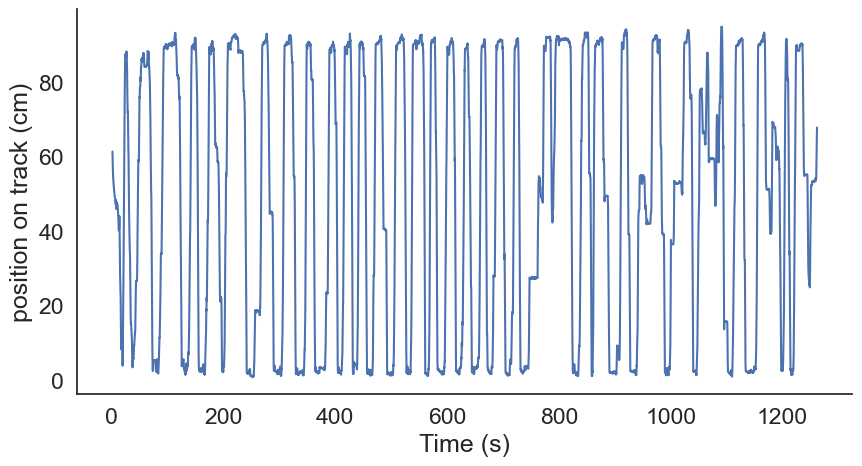

In [21]:
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']
t = data['t']
fps = np.median(np.diff(t))
spike_times = data['spikes']
n_cells = len(spike_times)
spike_positions = [np.interp(s, t, x) for s in spike_times]

plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')
plt.show()

def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spike_times[i], spike_positions[i], 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')


In [9]:
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=71), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

### Discussion:

We can see that there is no visible localization of the receptive fields along the track. Most of recorded cells do not show activity of place cells.

### B

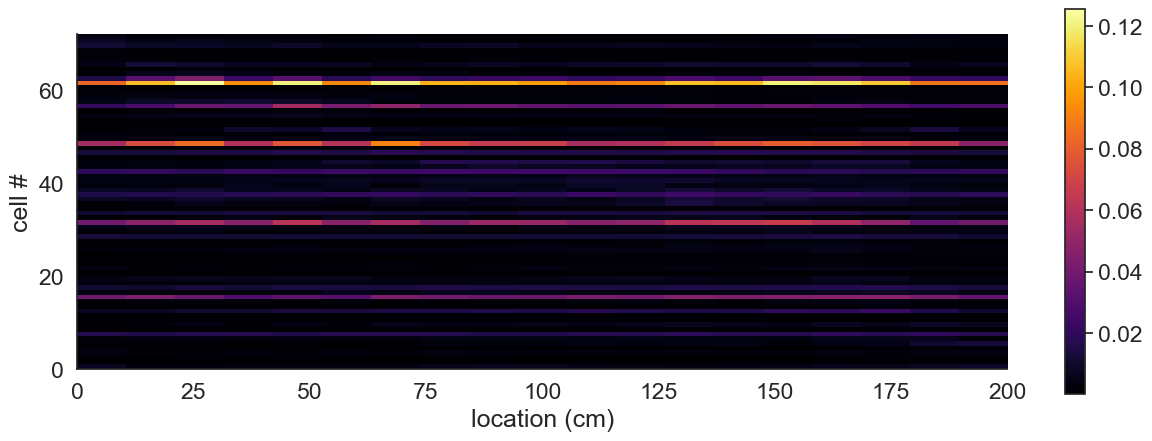

In [22]:
space_bins = np.arange(0,100, 5.)
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.vstack(spikes_hist).astype(np.float64)
occupancy = np.histogram(x, space_bins)[0]
occupancy = occupancy/fps
firing_rate_maps = spikes_hist / occupancy 
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

### Discussion

We can clearly see how far the biological data seems to be from the "ideal" synthetic data from the previous exercise.


### C

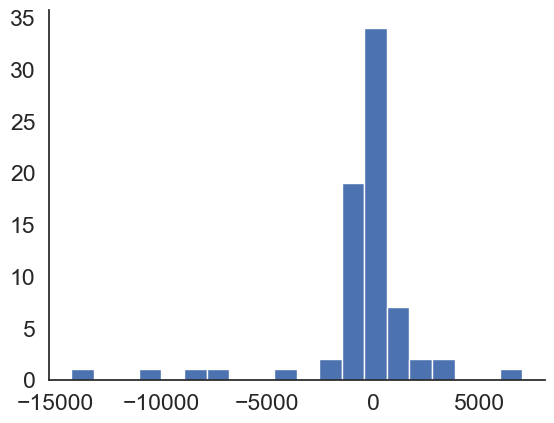

In [57]:
I_array = np.zeros(n_cells)
I_s_array = I_array.copy()


for n in range(n_cells):
    I_array[n] = I(firing_rate_maps[n, :], occupancy)
plt.hist(I_array, label ="I", bins = 20)
plt.show()
sorted_neurons_idx = np.flip(np.argsort(I_array))

There is something wrong here, as this should not give negative values for the information. See discussion.

I still plotted the three "best" neurons:

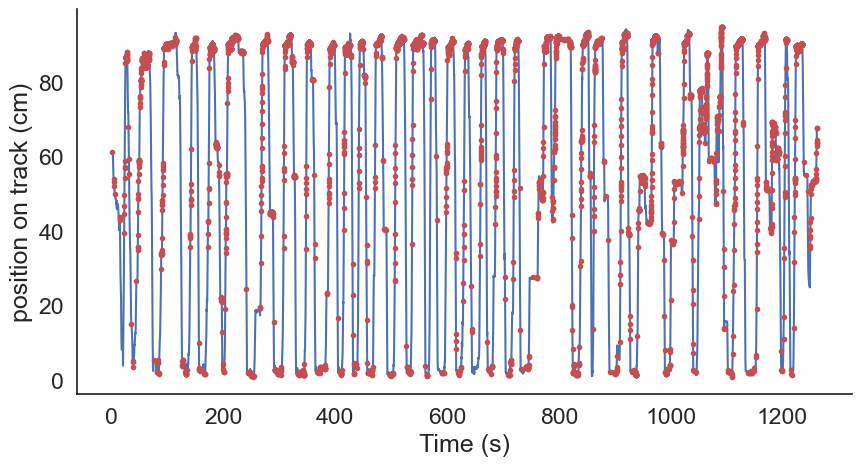

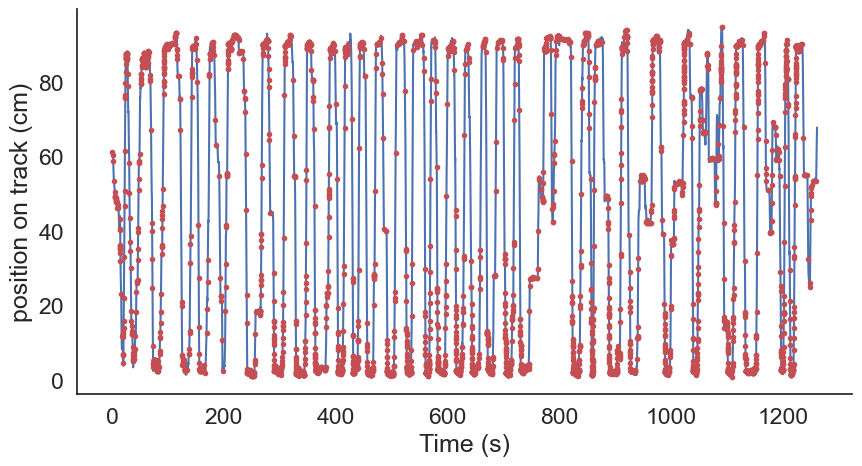

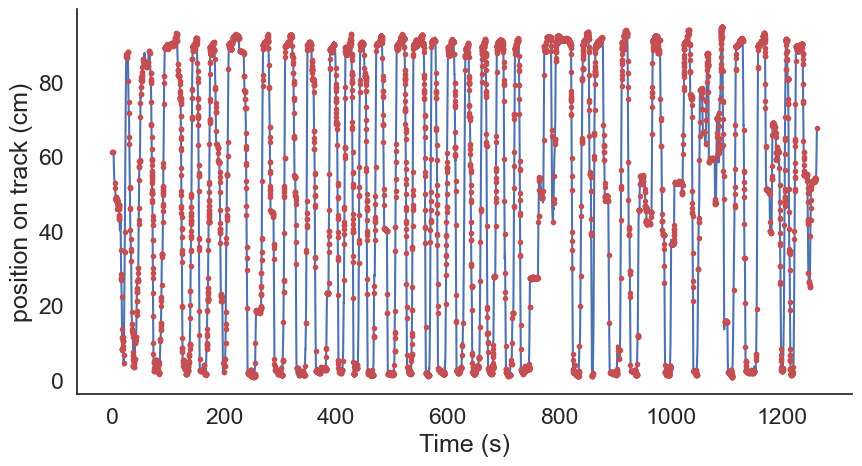

In [58]:
for n in range(3):
    plot_unit(sorted_neurons_idx[n])


### Discussion

Here, for some reason, we get negative spatial information content. This is obviously incorrect and points at a bug in the code. However, I am not sure where the bug is. An obvious idea might have been that I was also summing over rates that were 0 or points not visited. Thus, I introduced a mask in the computation of I. This did not fix the problem.

A second idea might be a problem in the normalization. However, we are using occupancy and firing_rate_maps that are both not normalized intentionally, since we left a scaling factor of dt in the expression. I did try to do it anyways (screwing up the scaling, I believe).

Both of these did not fix the issue. I am unsure what I got wrong.

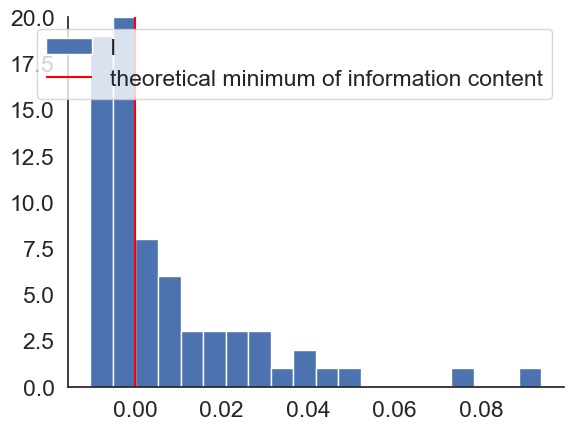

In [59]:
I_array = np.zeros(n_cells)
I_s_array = I_array.copy()
def I_safe(firing_rate_maps, occupancy):

    rate = firing_rate_maps/np.sum(firing_rate_maps)
    p = occupancy/np.sum(occupancy)
    mask = (rate>0)&(p>0)
    avrg_rate = np.mean(rate)
    I = np.sum(rate[mask]*p[mask]*np.log2((rate[mask])/avrg_rate))
    return I

for n in range(n_cells):
    I_array[n] = I_safe(firing_rate_maps[n, :], occupancy)


plt.hist(I_array, label ="I", bins = 20)
plt.vlines(x=[0], ymin = 0, ymax = 20, colors=['red'], label ="theoretical minimum of information content")
plt.ylim(0,20)
plt.legend()

